<a href="https://colab.research.google.com/github/Sevenc1over/AI-class/blob/main/WISDM/WISDM_CNN%2BGRU_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [153]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Conv1D, MaxPooling1D, Input, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [154]:
df = pd.read_csv('/content/drive/MyDrive/WISDM.csv', header=None)
df.columns = ['id', 'user', 'activity', 'timestep', 'x_axis', 'y_axis', 'z_axis']
display(df.head())

,id,user,activity,timestep,x_axis,y_axis,z_axis
0,0,33,Jogging,4.910600e+13,-0.694638,12.680544,0.503953
1,1,33,Jogging,4.910610e+13,5.012288,11.264028,0.953424
2,2,33,Jogging,4.910610e+13,4.903325,10.882658,-0.081722
3,3,33,Jogging,4.910620e+13,-0.612916,18.496431,3.023717
4,4,33,Jogging,4.910630e+13,-1.184970,12.108489,7.205164


In [155]:
df.shape

(1048575, 7)

timestep이 0인 데이터는 x,y,z 값 또한 0이였습니다. 이에 근거해 센서에 입력되지 못한 결측치라 판단하고 제거합니다.

In [156]:
df = df[df['timestep'] != 0]

In [157]:
df.shape

(1035733, 7)

id값 제거

In [158]:
df = df.drop(columns=['id'])
df.columns

Index(['user', 'activity', 'timestep', 'x_axis', 'y_axis', 'z_axis'], dtype='object')

In [159]:
df[['x_axis', 'y_axis', 'z_axis']].dtypes

,0
x_axis,float64
y_axis,float64
z_axis,float64


In [160]:
# LabelEncoder 객체 생성
encoder = LabelEncoder()

# activity 문자열 → 정수 인코딩
df['activity'] = encoder.fit_transform(df['activity'])

# 결과 확인
display(df.head())

# 어떤 클래스가 어떤 숫자로 바뀌었는지 확인
encoder.classes_, encoder.transform(encoder.classes_)

,user,activity,timestep,x_axis,y_axis,z_axis
0,33,1,4.910600e+13,-0.694638,12.680544,0.503953
1,33,1,4.910610e+13,5.012288,11.264028,0.953424
2,33,1,4.910610e+13,4.903325,10.882658,-0.081722
3,33,1,4.910620e+13,-0.612916,18.496431,3.023717
4,33,1,4.910630e+13,-1.184970,12.108489,7.205164


(array(['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs',
        'Walking'], dtype=object),
 array([0, 1, 2, 3, 4, 5]))

스캐일링

In [161]:
from sklearn.preprocessing import StandardScaler

# 스케일러 생성
scaler = StandardScaler()

# 스케일링할 컬럼 지정
cols = ['x_axis', 'y_axis', 'z_axis']

# 스케일링 적용
df[cols] = scaler.fit_transform(df[cols])

# 결과 확인
df.head()


,user,activity,timestep,x_axis,y_axis,z_axis
0,33,1,4.910600e+13,-0.221731,0.779657,0.014741
1,33,1,4.910610e+13,0.620736,0.567646,0.107925
2,33,1,4.910610e+13,0.604651,0.510567,-0.106682
3,33,1,4.910620e+13,-0.209667,1.650122,0.537139
4,33,1,4.910630e+13,-0.294115,0.694037,1.404039


슬라이딩 윈도우 적용

In [162]:
import numpy as np
from scipy import stats

def sliding_window_mode(df, window_size=100, step_size=50):
    X_list = []
    y_list = []

    x = df['x_axis'].values
    y = df['y_axis'].values
    z = df['z_axis'].values
    labels = df['activity'].values

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size

        window_data = np.vstack([
            x[start:end],
            y[start:end],
            z[start:end]
        ]).T

        #keepdims=True 이것이 false면 배열이 아닌 스칼라값 반환이 가능합니다.
        window_label = stats.mode(labels[start:end], keepdims=True).mode[0]

        X_list.append(window_data)
        y_list.append(window_label)

    return np.array(X_list), np.array(y_list)

In [163]:
X_data, y_data = sliding_window_mode(df, window_size=100, step_size=50)
print("X_data shape:", X_data.shape)
print("y_data shape:", y_data.shape)

X_data shape: (20713, 100, 3)
y_data shape: (20713,)


In [164]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=42, stratify = y_data)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify = y_test)


모델 구성

In [165]:
model = Sequential([
    Input(shape=(100, 3)),

    Conv1D(64, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(128, kernel_size=5, padding='same', activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    GRU(128, return_sequences=True),
    BatchNormalization(),

    GRU(128, return_sequences=True),
    BatchNormalization(),

    GRU(64, return_sequences=False),
    BatchNormalization(),
    Dropout(0.5),


    Dense(32, activation='relu'),
    Dropout(0.4),

    Dense(6, activation='softmax')
])

In [166]:
#모델 컴파일하기
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [167]:
model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_16 (Conv1D)              │ (None, 100, 64)        │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 100, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_16 (MaxPooling1D) │ (None, 50, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_17 (Conv1D)              │ (None, 50, 128)        │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_41          │ (None, 50, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_17 (MaxPooling1D) │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_24 (GRU)                    │ (None, 25, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_42          │ (None, 25, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_25 (GRU)                    │ (None, 25, 128)        │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_43          │ (None, 25, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_26 (GRU)                    │ (None, 64)             │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_44          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 281,830 (1.08 MB)

 Trainable params: 280,806 (1.07 MB)

 Non-trainable params: 1,024 (4.00 KB)

In [168]:
model_gru = model.fit(X_train, y_train, epochs=30 , batch_size=64, validation_data=(X_val, y_val))

Epoch 1/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 9s 20ms/step - accuracy: 0.6486 - loss: 1.0502 - val_accuracy: 0.7432 - val_loss: 0.7630
Epoch 2/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.8741 - loss: 0.3635 - val_accuracy: 0.9501 - val_loss: 0.1594
Epoch 3/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - accuracy: 0.9383 - loss: 0.2070 - val_accuracy: 0.9488 - val_loss: 0.1739
Epoch 4/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.9589 - loss: 0.1541 - val_accuracy: 0.9714 - val_loss: 0.0973
Epoch 5/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9635 - loss: 0.1410 - val_accuracy: 0.9678 - val_loss: 0.1084
Epoch 6/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9725 - loss: 0.1069 - val_accuracy: 0.9768 - val_loss: 0.0868
Epoch 7/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9701 - loss: 0.1093 - val_accuracy: 0.9775 - val_loss: 0.0831
Epoch 8/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9751 - loss: 0.0968 - val_accu

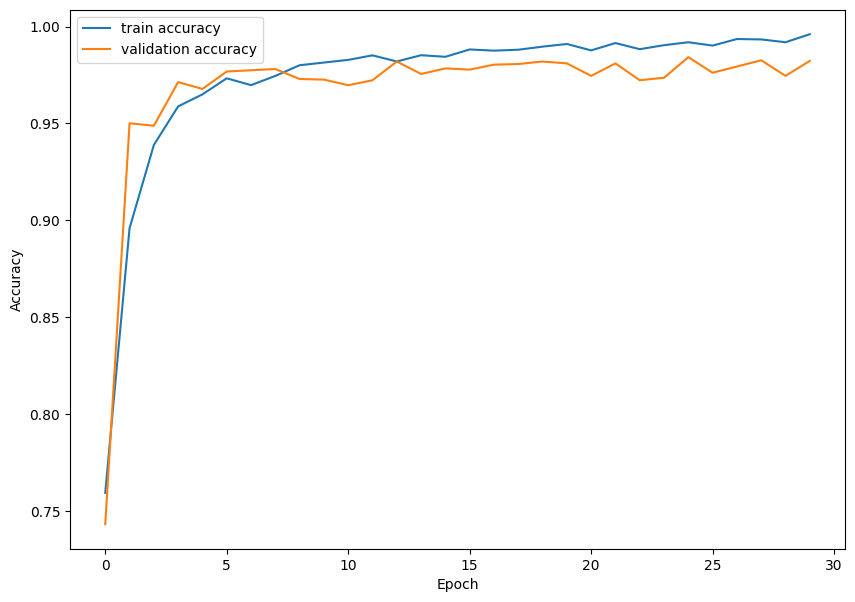

In [169]:
# accuracy 체크
import matplotlib.pyplot as plt

N_EPOCHS = 30 # 에포크 수 정의
history = model_gru # 학습 히스토리 변수 사용

plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), history.history['accuracy'], label='train accuracy')
plt.plot(range(N_EPOCHS), history.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

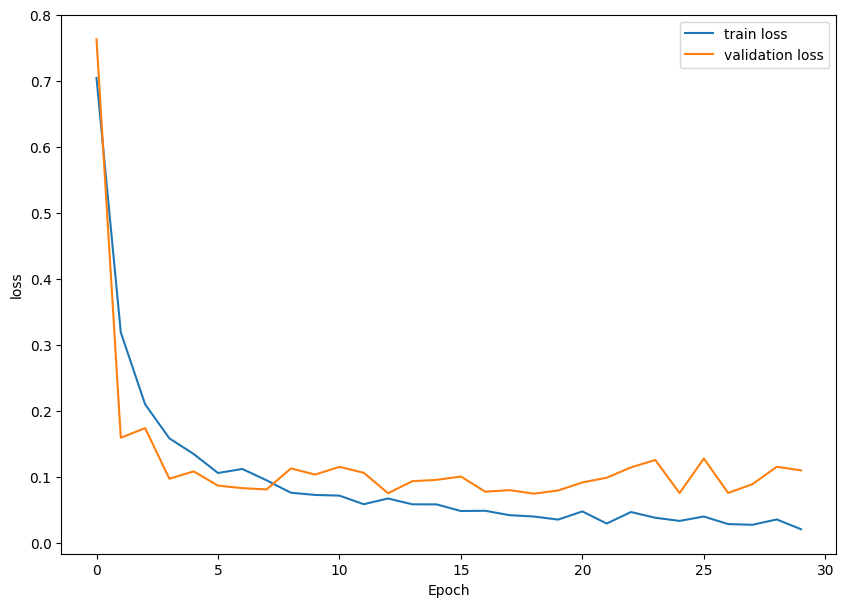

In [170]:
# loss 체크
import matplotlib.pyplot as plt

N_EPOCHS = 30 # 에포크 수 정의
history = model_gru # 학습 히스토리 변수 사용

plt.figure(figsize=(10,7))
plt.plot(range(N_EPOCHS), history.history['loss'], label='train loss')
plt.plot(range(N_EPOCHS), history.history['val_loss'], label='validation loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

test 데이터 비교

 Total params: 72,422 (282.90 KB)

 Trainable params: 71,910 (280.90 KB)

 Non-trainable params: 512 (2.00 KB)

1차 98.39%      1분

2차 98.29%      1분

3차 98.29%      1분

4차 98.33%      1분

---------------------

 Total params: 528,870 (2.02 MB)

 Trainable params: 527,590 (2.01 MB)

 Non-trainable params: 1,280 (5.00 KB)


5차 97.49%     2분

6차 98.33%     2분

7차 98.23%     2분

---------------------

 Total params: 281,830 (1.08 MB)

 Trainable params: 280,806 (1.07 MB)

 Non-trainable params: 1,024 (4.00 KB)

8차 98.71%     2분

9차 98.29%     2분

10차 98.17%    2분

---------------------

파라미터 차이와 별개로 비슷한 결과가 나온 것 같습니다.

In [171]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test accuracy: {test_acc:.2%}")

98/98 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9809 - loss: 0.0994
Test accuracy: 98.17%


WISDM_CNN+GRU와 달리 과적합이 일어나지 않은 이유
  
1. 스캐일링

 이전 프로그램은 user별로 데이터를 나누고 각각 스캐일링을 진행, 이후 train, test, val 데이터로 나누고 스캐일링을 진행했습니다.

 이런 부분은 train과정 데이터와 검증 데이터 사이 스캐일링이 일어나지 않았기에 데이터의 과적합에 영향을 주었을 것이라 예상됩니다.

 2. user 데이터

 user 데이터별로 train val test데이터를 나누었습니다.

 user별로 같은 activity여도 x,y,z 데이터의 시계열 데이터의 상관관계의 수치는 user별로 다를 것이기에 이를 구분해야 한다 판단했습니다. 허나 이 부분이 훈련과정에 있어 activity의 행동뿐만 아닌 user의 개인 특징까지 학습해, 새로운 user데이터에 적응하지 못하는 과적합이 일어났다 생각합니다.

 3. 슬라이딩 윈도우-1

슬라이딩 윈도우에 관한 아이디어는 데이터가 섞여 시간적인 특징을 잃을 것을 고려해 적용했습니다. 허나 잘못된 사용으로 시계열 데이터를 user 데이터 끼리 정렬할때 섞고 슬라이딩 윈도우를 적용했습니다.

이는 시간적 특징을 유지시키기 위한 초기 목적에 실패했습니다.

4. 슬라이딩 윈도우-2

슬라이딩 윈도우를 데이터에 적용하고 한 세트의 activity를 정한 방식이 마지막으로 입력된 activity의 종류였습니다.

이는 99개의 'a' activity 데이터를 받아도 마지막에 'b' activity 데이터를 받으면 데이터셋을 b activity라고 분류하는 문제가 발생합니다.

위 코드는 activity 결정 기준을 '마지막 데이터 종류'에서 '데이터의 최빈값'으로 결정했습니다.


5. 정리

이전 코드 WISDM_CNN+GRU 코드와 과적합 유무의 차이는 데이터 전처리 과정에서 일어났다고 생각합니다.

6. 추가 개선점

윈도우 슬라이딩을 진행해도 여전히 2개의 서로다른 activity 데이터가 각각 51, 49의 비율로 입력 받으면 최빈값인 51의 activity를 반영할 것입니다. 이는 데이터에 있어 잘못된 데이터 49개를 학습시킬 수 있다 생각합니다.

전처리 과정에 있어 이러한 문제를 서로 다른 activity가 하나의 윈도우로 들어올 시 이를 중간에 강제로 멈추게 하는 것이 도움이 될 것이라 생각합니다.

또한 현재의 모델이 아닌 새로운 모델을 구성하면 추가적인 결과를 기대할 수 있으리라 생각합니다.
